In [231]:
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

from graphviz import Digraph

os.chdir("/home/project")
%matplotlib inline
# graphviz.set_jupyter_format("svg")

# About Micro Grad Replication
This is a replication version of [karpathy Andrej's](https://github.com/karpathy/micrograd) mircrograd package, which make the learning process into stages to see how the code was gradually improved. Here are the takeouts:

1. The easy way to explain the process of back propagation: a math expression and we do partial derivative on that for each neuron(cell)

2. Build a simple nn using scalers

   1. Introduce value object + basic operations
   2. Give an example of feed forward nn
   3. Visualize the nn the graph
   4. Back propagation implemention
        - In cell back propagation: 
            - Show the derivatives of a function
            - Chain rule: dL/dE = (dL / dF) * (dF / dE)
            - Grad accumulation
        - Semi-auto back propagation
        - full back propagation (style1, style2)
        - use pytorch to show the similarity

   5. Build MLP
        - The imprtance of zero grad!!!
        - build neuron, layer, mlp
          - forward
          - loss
          - zero_grad
          - backword

## Create Important Component

**Graph Visualization Component**

In [96]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format="svg", rankdir="LR"):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ["LR", "TB"]
    dot = Digraph(
        format=format, graph_attr={"rankdir": rankdir}
    )
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [117]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        # self._backward = None will cause error on the last node when you apply .backward() 'NoneType' object is not callable
        # unless you add some new logic on each function (since every function can be the last node)
        # we suggest you to create this "fake" function that return None to avoid the TypeError
        self._backward = lambda: None
        # we need to store prev info due to chain rule
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # https://en.wikipedia.org/wiki/Chain_rule#Multivariable_case
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return self * other**-1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return other + (-self)

    def __neg__(self):  # -self
        return self * -1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only support int/float now!"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        """We now wnat to use exp instead directly call tanh
        thus we need to handle division

        Returns:
            _type_: _description_
        """
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()

## Back Propagation
**Manual back-propagation**

In [99]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b") 
c = Value(10, label="c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"; L.grad = 1
L

Value(data=-8.0, grad=1)

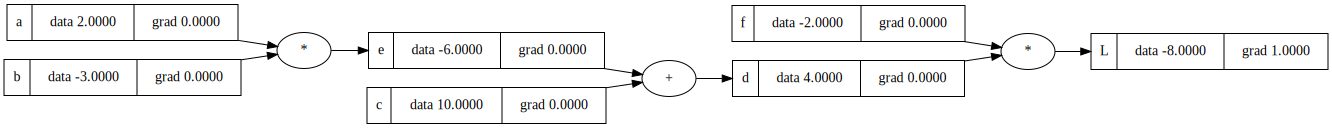

In [100]:
draw_dot(L)

In [101]:
# What is L = d * f
# dL / df = d
# dL / dd = f
d.grad = f.data
f.grad = d.data

# What is d = e + c
# dd / de = 1 -> dL / de = (dL / dd) * (dd / de) 
# dd / dc = 1 -> dL / dc = (dL / dd) * (dd / dc) 
e.grad = d.grad * 1
c.grad = d.grad * 1

# What is e = a * b
# de / da = b -> dL / da = (dL / dd) * (dd / de) * (de / da)
# de / db = a -> dL / db = (dL / dd) * (dd / de) * (de / db)
a.grad = e.grad * b.data
b.grad = e.grad * a.data

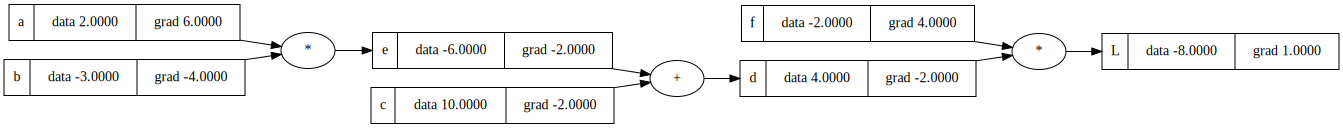

In [102]:
draw_dot(L)

In [103]:
def devirative_manual_check():
    # create a manual derivative: limit(h->0) (f(a+h) - f(a)) / h
    # min step size
    h = 0.001

    #  f(a+h)
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b") 
    c = Value(10, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data
    
    # f(a)
    a = Value(2.0, label="a")
    # a.data +=h 
    b = Value(-3.0, label="b") 
    # b.data += h
    c = Value(10, label="c")
    # c.data += h
    e = a * b; e.label = "e"
    # e.data += h
    d = e + c; d.label = "d"
    # d.data += h
    f = Value(-2.0 , label="f")  # +h
    L = d * f; L.label = "L"
    L2 = L.data # +h

    print((L2 - L1) / h)


devirative_manual_check()

0.0


**semi-auto backprpagation**

In [104]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2") 

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w3")
b = Value(6.8813735870195432, label="b")

w1x1 = w1 * x1; w1x1.label = "w1x1"
w2x2 = w2 * x2; w2x2.label = "w2x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1x1w2x2"
n = w1x1w2x2 + b; n.label = "n"
O = n.tanh(); O.label = "O"; O.grad = 1
O

Value(data=0.7071067811865476, grad=1)

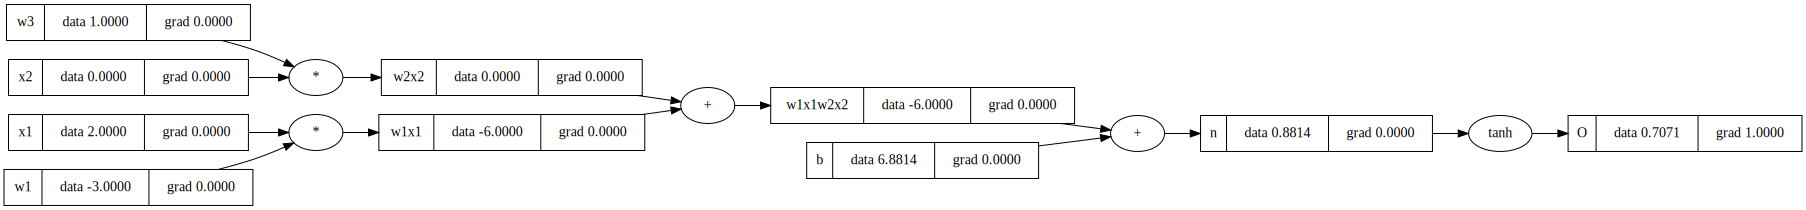

In [105]:
draw_dot(O)

In [106]:
O._backward()

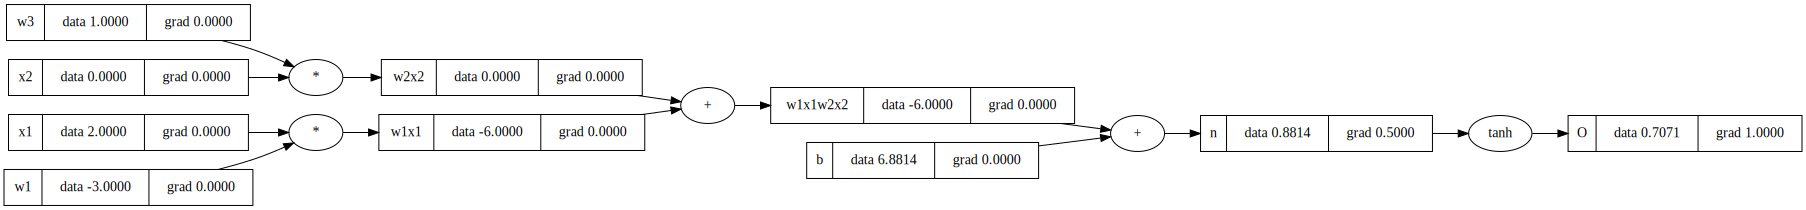

In [107]:
draw_dot(O)

In [108]:
n._backward()

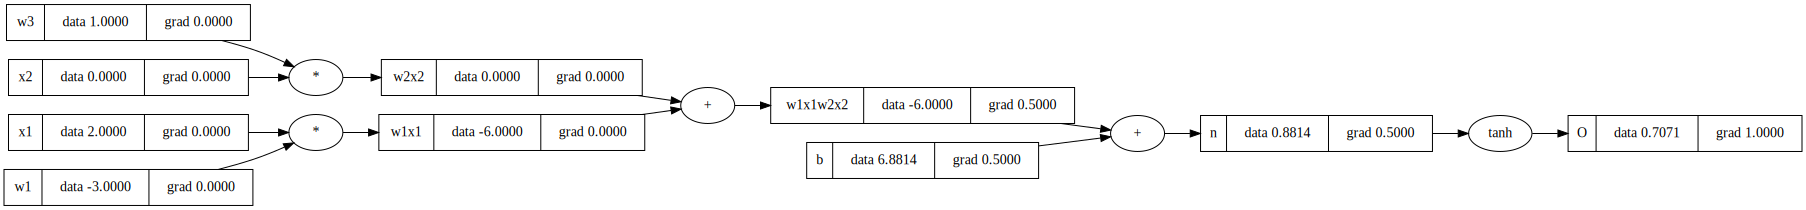

In [109]:
draw_dot(O)

In [110]:
w1x1w2x2._backward()
w2x2._backward()
w1x1._backward()
b._backward()

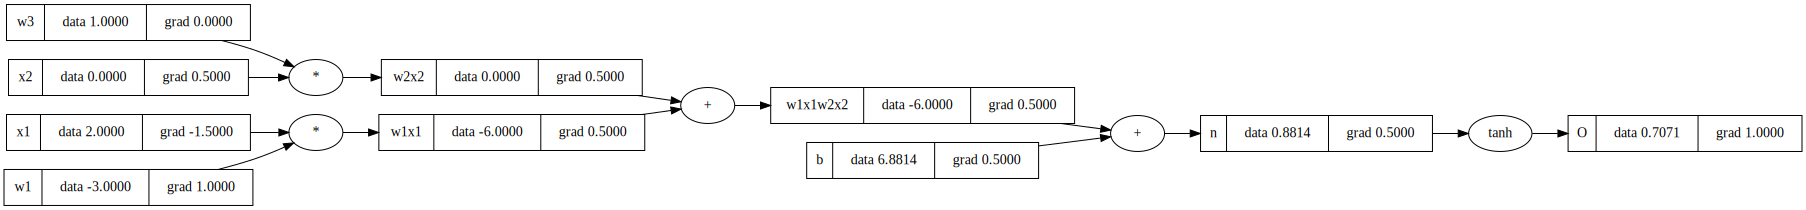

In [111]:
# usually we don't apply on first layer back propagation, especially the original data x.
draw_dot(O)

**Full back propagation**

In [112]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2") 

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w3")
b = Value(6.8813735870195432, label="b")

w1x1 = w1 * x1; w1x1.label = "w1x1"
w2x2 = w2 * x2; w2x2.label = "w2x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1x1w2x2"
n = w1x1w2x2 + b; n.label = "n"
O = n.tanh(); O.label = "O"
O

Value(data=0.7071067811865476, grad=0.0)

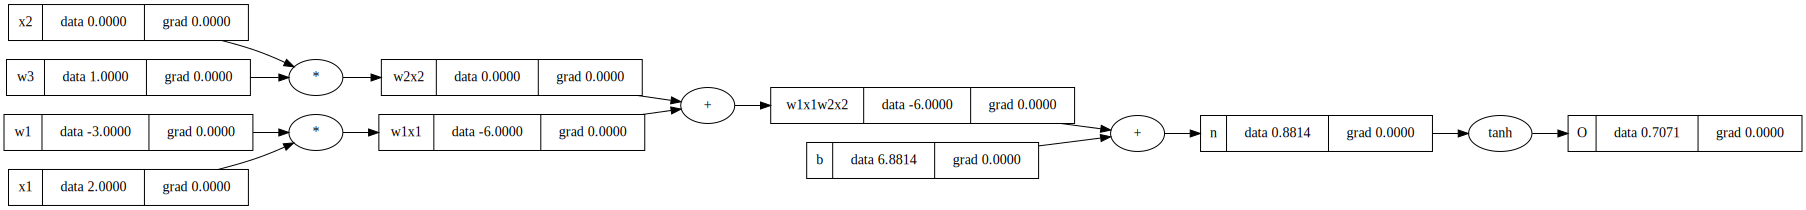

In [113]:
draw_dot(O)

In [114]:
O.backward()

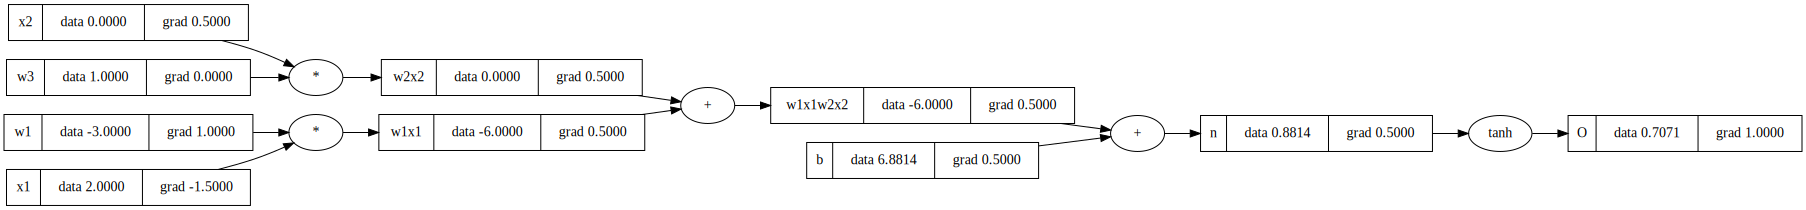

In [115]:
draw_dot(O)

**Full back propagation - Style 2**

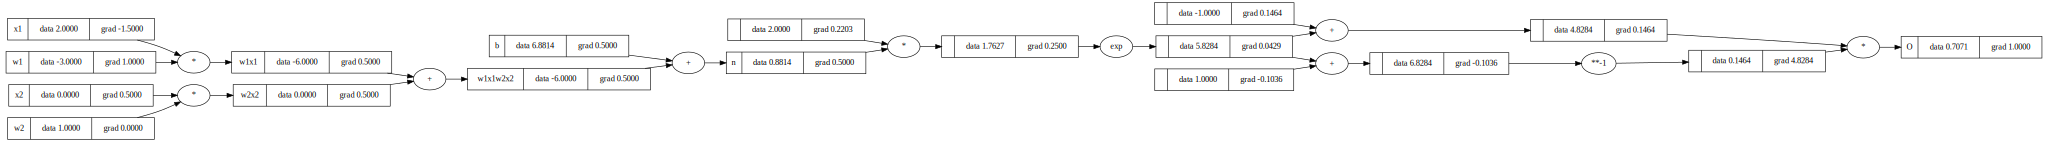

In [195]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2") 

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")

w1x1 = w1 * x1; w1x1.label = "w1x1"
w2x2 = w2 * x2; w2x2.label = "w2x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1x1w2x2"
n = w1x1w2x2 + b; n.label = "n"
# derivative of tanh using exp
e = (2 * n).exp()
O = (e - 1) / (e + 1)
O.label = "O"
O.backward()
draw_dot(O)

**Try in Pytorch**

In [226]:
x1 = torch.tensor([2.], requires_grad=True).double() # .to(torch.float64); 
# x1.requires_grad=True
x2 = torch.tensor([0.], requires_grad=True).double()
# x2.requires_grad=True
w1 = torch.tensor([-3.], requires_grad=True).double()
# x1.requires_grad=True
w2 = torch.tensor([1.], requires_grad=True).double()
# x1.requires_grad=True
b = torch.tensor([6.8813735870195432], requires_grad=True).double()
# Use: b.requires_grad = True or b.requires_grad_() if requires_grad=False at the beginning
n = w1 * x1 + w2 * x2 + b
o = n.tanh()
print(o.data.item())
x1.retain_grad()
# w1.retain_grad()
x2.retain_grad()
w2.retain_grad()
b.retain_grad()
o.backward()

0.7071066904050358


In [227]:
b.grad

tensor([0.5000], dtype=torch.float64)

In [228]:
w1.grad

/tmp/ipykernel_67031/1864339350.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  w1.grad


In [229]:
x1.grad

tensor([-1.5000], dtype=torch.float64)

## MLP

In [416]:
class ZeroGrad:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []


class Neuron(ZeroGrad):
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(0, nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x: float | int):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def __repr__(self):
        return f"{[cell.data for cell in self.w]}\n"

    def parameters(self):
        return self.w + [self.b]


class Layer(ZeroGrad):
    def __init__(self, nin: int, nout: int):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def __repr__(self):
        return f"Layer of [\n{''.join(str(n) for n in self.neurons)}]"

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP(ZeroGrad):
    def __init__(self, nin: int, nouts: list):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [427]:
mlp = MLP(3, [4,4,1])
# mlp.parameters()

In [428]:
x = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
y = [1, -1, -1, 1]

In [429]:
for epoch in range(10):
    # forward pass
    y_pred = [mlp(xi) for xi in x]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(y, y_pred)])
    print(f"epoch: {epoch}, loass {loss.data}, prediction: {[pred.data for pred in y_pred]}")
    # zero grad to avoid accumalate the new grad with old grad
    mlp.zero_grad()
    # backprop
    loss.backward()
    # update weights according to gradient
    for p in mlp.parameters():
        p.data -= 0.1 * p.grad

epoch: 0, loass 5.445267486657402, prediction: [0.7958610496902417, 0.4745794257427483, 0.7026893231944641, 0.425492070133408]
epoch: 1, loass 5.471061604041477, prediction: [-0.5390690933996026, -0.8871917750251177, -0.7075710047898448, -0.7332303704130038]
epoch: 2, loass 5.283518013909879, prediction: [0.8888536700711867, 0.44019500514749366, 0.7829961040137708, 0.8661054613766502]
epoch: 3, loass 2.2846596777685875, prediction: [0.0019062821611388605, -0.8479205344998656, -0.5030072602568894, -0.00912767328768522]
epoch: 4, loass 2.601392233730617, prediction: [0.9115572983573765, -0.44192949436206347, 0.5067021194425856, 0.8905643738949273]
epoch: 5, loass 0.9701472693568434, prediction: [0.32308812339207565, -0.9456744503007409, -0.9106103448259296, 0.2921894286875084]
epoch: 6, loass 0.12773093344833106, prediction: [0.9434914808165118, -0.8570123184234317, -0.6883666042591531, 0.91647233820819]
epoch: 7, loass 0.05567353888806441, prediction: [0.9383260911257156, -0.90346169684